In [109]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils import data as data_utils

In [110]:
data = pd.read_csv('E:/RTC/skill-task2/data/train.csv/train.csv')

In [111]:
data.head()

,sample_id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f1603,f1604,f1605,f1606,f1607,f1608,f1609,f1610,f1611,y
0,sample_0,25.609375,6.703125,3.652344,10.039062,169.375,102.8125,1.422852,6.722656,8.015625,...,8.070312,4.363281,5.019531,5.710938,6.343750,6.843750,7.289062,7.617188,7.980469,1.0
1,sample_1,18.343750,5.824219,2.966797,4.902344,164.625,71.8125,1.357422,5.894531,2.753906,...,7.359375,4.195312,4.808594,5.425781,5.949219,6.339844,6.730469,7.074219,7.175781,1.0
2,sample_2,28.562500,6.230469,3.583984,7.882812,159.500,113.1875,1.696289,6.316406,4.605469,...,8.562500,4.523438,5.097656,5.789062,6.457031,6.871094,7.386719,7.878906,8.328125,1.0
3,sample_3,28.062500,6.132812,2.726562,6.378906,169.750,111.0000,1.535156,6.199219,3.712891,...,4.558594,3.533203,3.900391,4.261719,4.042969,3.869141,3.890625,4.042969,4.273438,1.0
4,sample_4,20.109375,6.144531,3.203125,6.035156,164.750,78.8750,1.281250,6.187500,4.003906,...,6.613281,4.625000,4.996094,5.328125,5.593750,5.800781,6.027344,6.242188,6.449219,0.0


In [112]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)
data = data.fillna(0)

In [113]:
X = data.drop(['sample_id', 'y'], axis=1)
y = data['y']

# Split in train/test
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [198]:
# Data normalization
from sklearn.preprocessing import StandardScaler 
scale_features_std = StandardScaler() 
X_train_std = scale_features_std.fit_transform(X_train) 
x_test_std = scale_features_std.fit_transform(x_test)

In [200]:
# To torch tensor: Train
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float)
Y_train_tensor = torch.tensor(Y_train.values).flatten() 

# Test
x_test_tensor = torch.tensor(x_test_std, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values).flatten() 

In [201]:
X_train_tensor.size()

torch.Size([876, 1612])

In [202]:
# Create train dataset
batch_size = 128

train_dataset = data_utils.TensorDataset(X_train_tensor, Y_train_tensor) 
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

In [203]:
for data, labels in train_loader:
    print(data.size())
    print(labels.size())
    break

torch.Size([128, 1612])
torch.Size([128])


In [204]:
X_train_tensor.size()

torch.Size([876, 1612])

In [205]:
len(train_loader)

7

In [128]:
128*6

768

In [206]:
import torch.nn.functional as F
#our class must extend nn.Module
class MyClassifier(nn.Module):
    def __init__(self):
        super(MyClassifier,self).__init__()
        #Our network consists of 3 layers. 1 input, 1 hidden and 1 output layer
        #This applies Linear transformation to input data. 
        self.fc1 = nn.Linear(1612,3200)
        self.fc2 = nn.Linear(3200,3200)
        self.fc3 = nn.Linear(3200,1600)
        
        #This applies linear transformation to produce output data
        self.fc4 = nn.Linear(1600,2)
        
        self.bn0 = nn.BatchNorm1d(1612)
        self.bn1 = nn.BatchNorm1d(3200)
        self.bn2 = nn.BatchNorm1d(3200)
        self.bn3 = nn.BatchNorm1d(1600)
        
        
    #This must be implemented
    def forward(self,x):
        #Output of the first layer
        x = self.bn0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        
        
        #This produces output
        
        x = self.fc4(x)
        return x
        
    #This function takes an input and predicts the class, (0 or 1)        
    def predict(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x))
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

In [207]:
#Initialize the model        
model = MyClassifier()
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [208]:
model

MyClassifier(
  (fc1): Linear(in_features=1612, out_features=3200, bias=True)
  (fc2): Linear(in_features=3200, out_features=3200, bias=True)
  (fc3): Linear(in_features=3200, out_features=1600, bias=True)
  (fc4): Linear(in_features=1600, out_features=2, bias=True)
  (bn1): BatchNorm1d(3200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(3200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(1600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [209]:
def train_model(model, optim, criterion, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        output = model(x)
        loss = criterion(output, y.long())   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
        # print("Batch loss: ", batch*(loss.item()))
    return sum_loss/total

In [210]:
#Number of epochs
epochs = 15
#List to store losses
losses = []
for i in range(epochs):
    epoch_loss = train_model(model=model, optim=optimizer, criterion=criterion, train_dl=train_loader)
    losses.append(epoch_loss)
    print("Epoch {0}, Loss {1}".format(i+1, epoch_loss))

Epoch 1, Loss 2.592891892341718
Epoch 2, Loss 0.546780363881969
Epoch 3, Loss 0.4888010246840786
Epoch 4, Loss 0.41284526333416977
Epoch 5, Loss 0.37902917410140713
Epoch 6, Loss 0.32865289221071214
Epoch 7, Loss 0.2953430107331167
Epoch 8, Loss 0.25992762729457525
Epoch 9, Loss 0.1943664913444214
Epoch 10, Loss 0.16264918065506573
Epoch 11, Loss 0.13211341038958668
Epoch 12, Loss 0.10742723458705972
Epoch 13, Loss 0.12470945719306327
Epoch 14, Loss 0.100245250652642
Epoch 15, Loss 0.13673679020306836


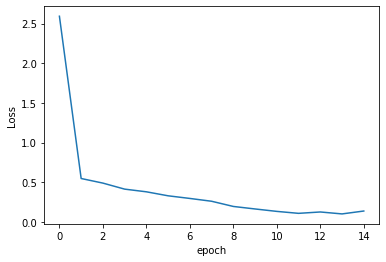

In [211]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [212]:
from sklearn import metrics

y_preds = model.predict(x_test_tensor)
print(metrics.classification_report(y_test_tensor.long(), y_preds))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71        82
           1       0.82      0.86      0.84       137

    accuracy                           0.79       219
   macro avg       0.78      0.77      0.78       219
weighted avg       0.79      0.79      0.79       219



E:\Program_Files\Anaconda3\envs\stepik_mipt\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [213]:
from sklearn.metrics import accuracy_score
print(accuracy_score(model.predict(x_test_tensor),y_test_tensor.long()))

0.7945205479452054


E:\Program_Files\Anaconda3\envs\stepik_mipt\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
